スパースモデリング第14章　画像のノイズ除去
==
ウェーブレット縮小、DCT縮小、縮小曲線学習

In [1]:
from matplotlib.font_manager import FontProperties
from scipy.fftpack import dct, idct
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread
import pywt

font_path = u'/Library/Fonts/ヒラギノ角ゴ Pro W3.otf'
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def get_2D_dct(img):
    """ 2D DCT """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coeffs):
    """ 2D inverse DCT """
    return idct(idct(coeffs.T, norm='ortho').T, norm='ortho')

def show_dictionary(A, name=None):
    """ 辞書を表示 """
    n = int(np.sqrt(A.shape[0]))
    m = int(np.sqrt(A.shape[1]))
    A_show = A.reshape((n, n, m, m))
    fig, ax = plt.subplots(m, m, figsize=(4, 4))
    for row in range(m):
        for col in range(m):
            ax[row, col].imshow(A_show[:, :, col, row], cmap='gray', interpolation='Nearest')
            ax[row, col].axis('off')
    if name is not None:
        plt.savefig(name, dpi=220)

Barbara
--

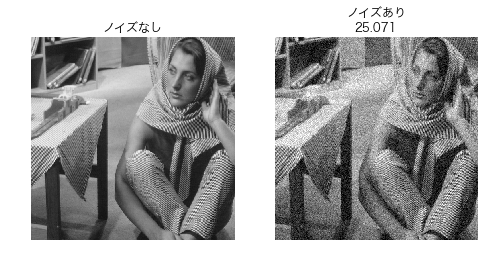

In [2]:
im = imread('barbara.png').astype(np.float)
# Y = im + np.random.randn(im.shape[0], im.shape[1]) * 20.
# Y.tofile('barbara_sig20')
Y = np.fromfile('barbara_sig20').reshape(im.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(im, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
ax[1].imshow(Y, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('ノイズなし')
ax[1].set_title('ノイズあり\n{:.3f}'.format(get_psnr(im, Y)))
plt.savefig('barbara_sig20.png', dpi=220)

ウェーブレット縮小
--

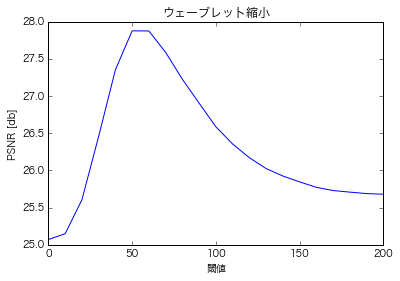

In [4]:
def wavelet_shrinkage(im, t, level, hard=True):
    """ ウェーブレット縮小 """
    Ds = []
    L = im.copy()
    for _ in range(level):
        L, D = pywt.dwt2(L, 'haar')
        if hard:
            D = np.where(np.abs(D) > t, D, 0)
        else:
            D = np.where(np.abs(D) > t, np.sign(D) * (np.abs(D) - t), 0)
        Ds.append(D)
    for l in range(level):
        L = pywt.idwt2((L, Ds[-(l + 1)]), 'haar')
    return L

log = []
opt_max = 0
for t in np.linspace(0, 200, 21):
    recon = wavelet_shrinkage(Y, t, 2)  
    opt = get_psnr(im, recon)
    log.append(opt)
    if opt > opt_max:
        recon_max = recon.copy()
        opt_max = opt
        
recon_ws = recon_max.copy()
recon_ws.tofile('recon_ws')    
    
plt.plot(np.linspace(0, 200, 21), log)
plt.ylabel('PSNR [db]')
plt.xlabel('閾値')
plt.title('ウェーブレット縮小')
plt.savefig('wavelet_shrinkage_threshold.png', dpi=220)

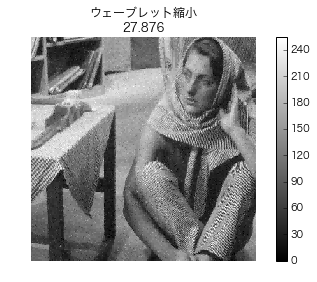

In [3]:
recon_ws = np.fromfile('recon_ws').reshape(im.shape)
plt.imshow(recon_ws, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
plt.axis('off')
plt.title('ウェーブレット縮小\n{:.3f}'.format(get_psnr(im, recon_ws)))
plt.colorbar()
plt.tight_layout()
plt.savefig('wavelet_shrinkage.png', dpi=220)

パッチベースDCT縮小
--

0.0 25.0705314956
10.0 25.2495243326
20.0 25.9286603377
30.0 26.927791849
40.0 27.9232115703
50.0 28.6004636966
60.0 28.8444289278
70.0 28.7026824538
80.0 28.3439922391
90.0 27.9214838579
100.0 27.5010150853
110.0 27.1322841387
120.0 26.8073725645
130.0 26.5091739727
140.0 26.2462478558
150.0 26.0177563846
160.0 25.8083375163
170.0 25.6159154487
180.0 25.4525483496
190.0 25.2954245037
200.0 25.1618004848


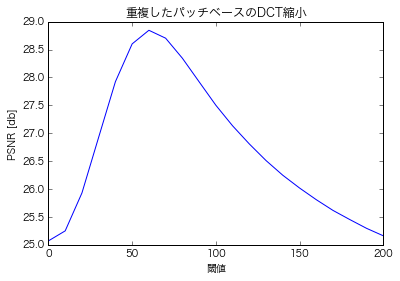

In [11]:
def dct_shrinkage(im, t, patch_size=8, hard=True):
    """ DCT縮小 """
    patches = extract_patches_2d(im, (patch_size, patch_size))
    coeffs = get_2D_dct(patches)
    if hard:
        coeffs = np.where(np.abs(coeffs) > t, coeffs, 0)
    else:
        coeffs = np.where(np.abs(coeffs) > t, np.sign(coeffs) * (np.abs(coeffs) - t), 0)
    patches = get_2d_idct(coeffs)        
    return reconstruct_from_patches_2d(patches, im.shape)
    
log = []
opt_max = 0
for t in np.linspace(0, 200, 21):
    recon = dct_shrinkage(Y, t, 2)  
    opt = get_psnr(im, recon)
    print(t, opt)
    log.append(opt)
    if opt > opt_max:
        recon_max = recon.copy()
        opt_max = opt
        
recon_dct_shrink = recon_max.copy()
recon_dct_shrink.tofile('recon_dct_shrink')

plt.plot(np.linspace(0, 200, 21), log)
plt.ylabel('PSNR [db]')
plt.xlabel('閾値')
plt.title('重複したパッチベースのDCT縮小')
plt.savefig('dct_shrinkage_threshold.png', dpi=220)

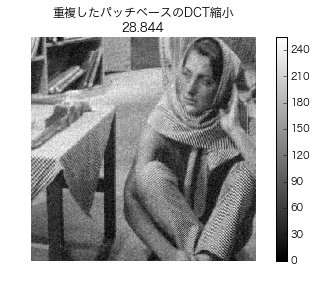

In [5]:
recon_dct_shrink = np.fromfile('recon_dct_shrink').reshape(im.shape)

plt.imshow(recon_dct_shrink, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
plt.axis('off')
plt.title('重複したパッチベースのDCT縮小\n{:.3f}'.format(get_psnr(im, recon_dct_shrink)))
plt.colorbar()
plt.tight_layout()
plt.savefig('dct_shrinkage.png', dpi=220)

Lena
--

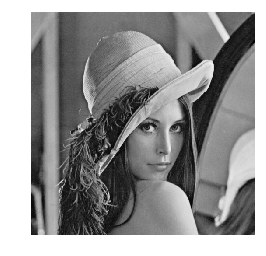

In [13]:
lena = imread('lena.jpg', as_grey=True) * 255

plt.imshow(lena, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.savefig('lena.png', dpi=220)

縮小曲線の学習に用いる画像
--

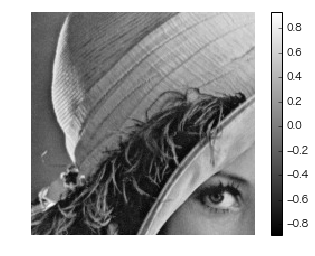

In [14]:
target = lena[100:300, 100:300]
noisy = target + np.random.randn(200, 200) * 20

target = (target - 127.) / 128.
noisy = (noisy - 127.) / 128.

plt.imshow(target, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.colorbar()
plt.savefig('lena_200_200.png', dpi=220)

縮小曲線を学習
--

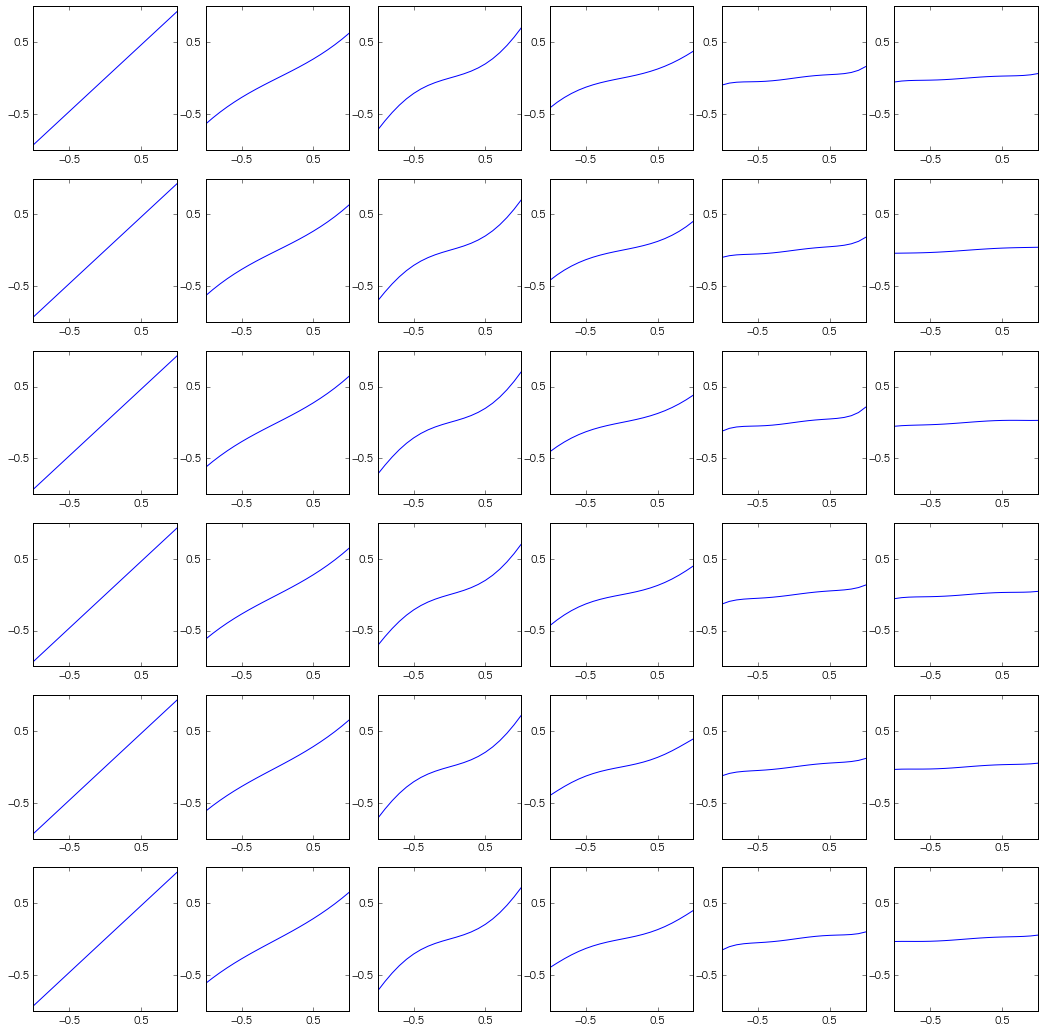

In [24]:
def get_shrinkage_curve(target, noisy, J=6, patch_size=6):
    """ 縮小曲線を得る """
    target_patches = extract_patches_2d(target, (patch_size, patch_size))
    noisy_patches = extract_patches_2d(noisy, (patch_size, patch_size))

    target_coeffs = get_2D_dct(target_patches).reshape((-1, patch_size ** 2))
    noisy_coeffs = get_2D_dct(noisy_patches).reshape((-1, patch_size ** 2))

    b = np.zeros((len(noisy_coeffs), J))
    c = np.zeros((patch_size ** 2, J))
    for m in range(patch_size ** 2):
        for j in range(J):
            b[:, j] = noisy_coeffs[:, m] ** j
        bb = np.dot(b.T, b)
        bt = np.dot(b.T, target_coeffs[:, m])
        c[m] = np.dot(np.linalg.pinv(bb), bt)

    return c, noisy_patches.min(), noisy_patches.max()

def plot_shrinkage_curve(c, J=6, patch_size=6):
    """ 縮小曲線を表示 """
    fig, ax = plt.subplots(6, 6, figsize=(18, 18))
    ax = ax.flatten()
    x = np.linspace(-1, 1, 21)
    for i in range(patch_size ** 2):
        y = np.zeros_like(x)
        for j in range(J):
            y += (x ** j) * c[i * J + j]
        ax[i].plot(x, y)
        ax[i].set_ylim(-1, 1)
        ax[i].set_yticks([-0.5, 0.5])
        ax[i].set_xticks([-0.5, 0.5])

c_local, sc_min, sc_max = get_shrinkage_curve(target, noisy)
c_local.tofile('c_local')
plot_shrinkage_curve(c_local.flatten())

In [6]:
def dct_with_shrinkage_curve(im, c, sc_min, sc_max, patch_size=6):
    """ 重複したパッチベースのDCT縮小曲線学習 """
    patches = extract_patches_2d(im, (patch_size, patch_size))
    patches = (patches - 127.) / 128.
    coeffs = get_2D_dct(patches).reshape((-1, patch_size ** 2))
    for m in range(patch_size ** 2):
        x = coeffs[:, m]
        y = np.zeros_like(x)
        for j in range(c.shape[1]):
            y += (x ** j) * c[m, j]
        roi = (sc_min <= x) * (x <= sc_max)
        coeffs[roi, m] = y[roi]
    patches = get_2d_idct(coeffs.reshape((-1, patch_size, patch_size)))        
    patches = patches * 128 + 127
    return reconstruct_from_patches_2d(patches, im.shape)

recon_dct_shrinkage_curve = dct_with_shrinkage_curve(Y, c_local, sc_min, sc_max)
recon_dct_shrinkage_curve.tofile('recon_dct_shrinkage_curve')

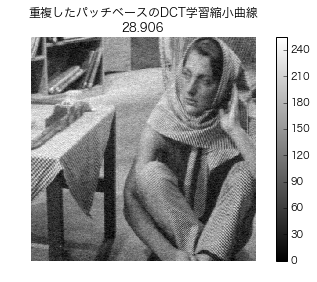

In [7]:
recon_dct_shrinkage_curve = np.fromfile('recon_dct_shrinkage_curve').reshape(im.shape)

plt.imshow(recon_dct_shrinkage_curve, cmap='gray', interpolation='Nearest', vmin=0, vmax=255)
plt.axis('off')
plt.title('重複したパッチベースのDCT学習縮小曲線\n{:.3f}'.format(get_psnr(im, recon_dct_shrinkage_curve)))
plt.colorbar()
plt.tight_layout()
plt.savefig('recon_dct_shrinkage_curve.png', dpi=220)

DCT辞書
--

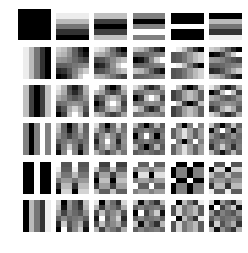

In [29]:
patch_size = 6
dict_size = 6
A_1D = np.zeros((patch_size, dict_size))
for k in np.arange(dict_size):
    for i in np.arange(patch_size):
        A_1D[i, k] = np.cos(i * k * np.pi / float(dict_size))
    if k != 0:
        A_1D[:, k] -= A_1D[:, k].mean()

A = np.kron(A_1D, A_1D)

show_dictionary(A)

パッチ間の重複を考慮して縮小曲線を学習
--

In [32]:
def get_shrinkage_curve_with_global_loss_function(target, noisy, J=6, patch_size=6):
    """ 大域的な損失関数を最小化して縮小曲線を学習 """
    
    noisy_patches = extract_patches_2d(noisy, (patch_size, patch_size))
    noisy_coeffs = get_2D_dct(noisy_patches).reshape((-1, patch_size ** 2))

    n = patch_size ** 2
    m = A.shape[1]
    M = noisy.shape[0] * noisy.shape[1]
    R = np.zeros((n, M))
    U = np.zeros((m, m * J))

    mat = np.zeros((m * J, M))
    mat2 = np.zeros((M, m * J))
    r = np.zeros(M)
    for k in range(0, len(noisy_patches), 1):
        if k % 400 == 0:
            print(k)
        # set R
        for row in range(patch_size):
            for col in range(patch_size):
                k1 = k + row * noisy.shape[1] + col
                r[:] = 0
                r[k1] = 1
                R[row * patch_size + col] = r
        # set U    
        for i in range(m):
            b = noisy_coeffs[k, i] 
            for j in range(J):
                U[i, i * J + j] = b ** j
        mat += np.dot(U.T, np.dot(A.T, R))
        mat2 += np.dot(R.T, np.dot(A, U))

    inv = np.linalg.pinv(np.dot(mat, mat2))
    c = np.dot(inv, np.dot(mat, target.reshape((target.shape[0] * target.shape[1], 1))))
    
    return c, noisy_patches.min(), noisy_patches.max()

c_global, sc_min, sc_max = get_shrinkage_curve_with_global_loss_function(target, noisy)
c_global.tofile('c_global')

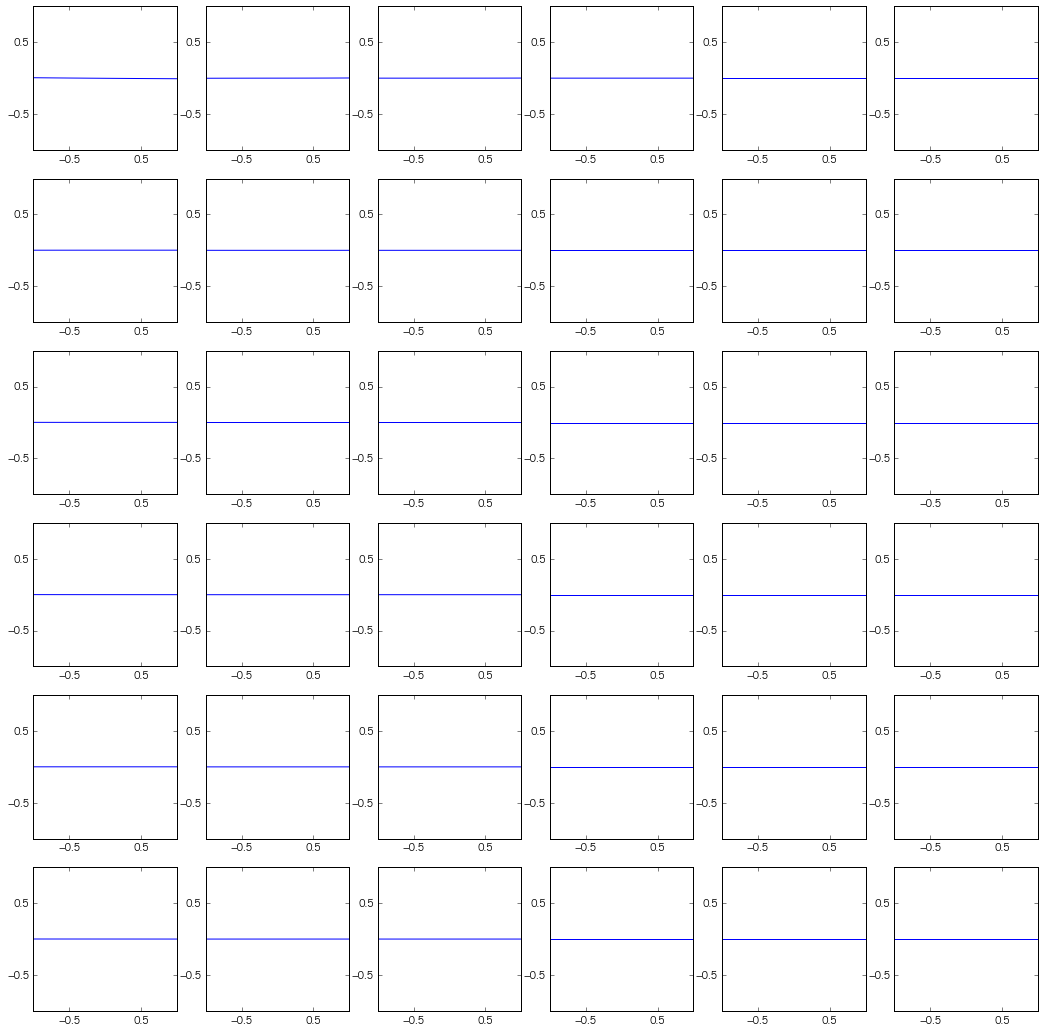

In [33]:
plot_shrinkage_curve(c_global)

In [8]:
def rdct_with_global_shrinkage_curve(im, c, sc_min, sc_max, A, patch_size=6):
    """ グローバルに学習した縮小曲線を使った冗長DCT """
    patches = extract_patches_2d(im, (patch_size, patch_size))
    patches = (patches - 127.) / 128.
    coeffs = np.dot(patches.reshape((-1, patch_size ** 2)), A)
    for m in range(patch_size ** 2):
        x = coeffs[:, m]
        y = np.zeros_like(x)
        for j in range(c.shape[1]):
            y += (x ** j) * c[m, j]
        roi = (sc_min <= x) * (x <= sc_max)
        coeffs[roi, m] = y[roi]
    patches = np.dot(coeffs, A.T).reshape((-1, patch_size, patch_size))
    patches = patches * 128 + 127
    return reconstruct_from_patches_2d(patches, im.shape)

recon_dct_global_shrinkage_curve = rdct_with_global_shrinkage_curve(Y, c_global, sc_min, sc_max, A)

# スケールがあわない…
recon_dct_global_shrinkage_curve -= recon_dct_global_shrinkage_curve.min()
recon_dct_global_shrinkage_curve *= im.max() / recon_dct_global_shrinkage_curve.max()

recon_dct_global_shrinkage_curve.tofile('recon_dct_global_shrinkage_curve')

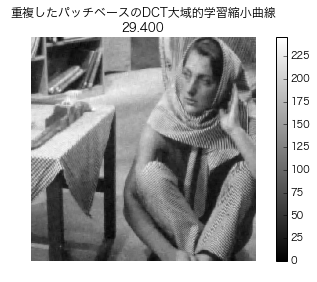

In [9]:
recon_dct_global_shrinkage_curve = np.fromfile('recon_dct_global_shrinkage_curve').reshape(im.shape)

plt.imshow(recon_dct_global_shrinkage_curve, cmap='gray', interpolation='Nearest')
plt.axis('off')
plt.title('重複したパッチベースのDCT大域的学習縮小曲線\n{:.3f}'.format(get_psnr(im, recon_dct_global_shrinkage_curve)))
plt.colorbar()
plt.tight_layout()
plt.savefig('recon_dct_global_shrinkage_curve.png', dpi=220)